In [1]:
!pip install -q bitsandbytes
!pip install -q accelerate
!pip install -q peft
!pip install -q datasets
!pip install -q trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 8.0 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
dbricks_15k_dataset_base = load_dataset("databricks/databricks-dolly-15k")
dbricks_15k_dataset_base

README.md:   0%|          | 0.00/8.20k [00:00<?, ?B/s]

databricks-dolly-15k.jsonl:   0%|          | 0.00/13.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15011 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 15011
    })
})

In [3]:
import matplotlib.pyplot as plt

def plot_length_sq(obj_data):
  sequence_lengths = [len(data['instruction']) + len(data['context']) + len(data['response']) for data in obj_data]
  plt.hist(sequence_lengths, bins=40)
  plt.xlabel('Sequence Length')
  plt.ylabel('Frequency')
  plt.title('Sequence Length Distribution')
  plt.show()

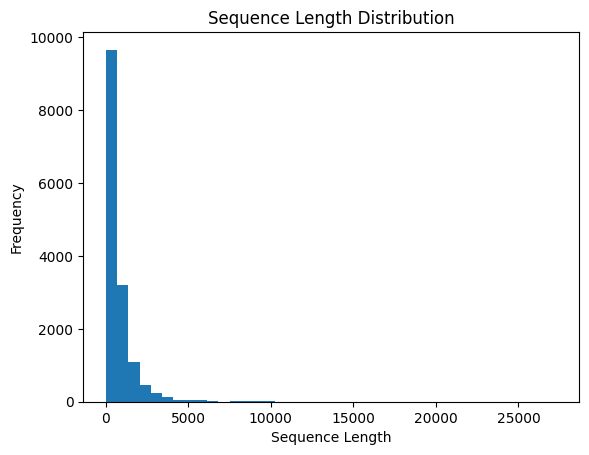

In [4]:
plot_length_sq(dbricks_15k_dataset_base['train'])

In [5]:
# Mark the index of samples that have the length >= 2500
def mark_too_long_samples(obj_data):
  too_long_indices = []
  for idx, data in enumerate(obj_data):
    sequence_length = len(data['instruction']) + len(data['context']) + len(data['response'])
    if sequence_length >= 2500:
      too_long_indices.append(idx)
  return too_long_indices

too_long_indices = mark_too_long_samples(dbricks_15k_dataset_base['train'])

In [6]:
# Select samples not in too_long_indices
droped_dataset = dbricks_15k_dataset_base['train'].select(set(range(len(dbricks_15k_dataset_base['train']))) - set(too_long_indices))

In [7]:
droped_dataset

Dataset({
    features: ['instruction', 'context', 'response', 'category'],
    num_rows: 14277
})

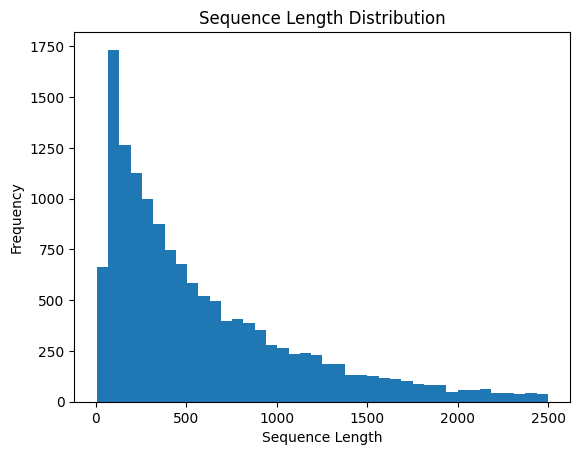

In [8]:
plot_length_sq(droped_dataset)

In [9]:
splited_dataset = droped_dataset.train_test_split(test_size=0.1)
splited_dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 12849
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 1428
    })
})

In [10]:
def clean_text(text):
    return text.strip() if isinstance(text, str) else ""

def build_prompt(instruction, context, response):
    base_prompt = "Below is an instruction that describes a task"
    if context:
        base_prompt += ", paired with an input that provides further context."

    prompt = (
        f"{base_prompt}\n\n"
        f"### Instruction:\n{instruction}\n\n"
    )

    if context:
        prompt += f"### Input:\n{context}\n\n"

    prompt += f"### Response:\n{response}"
    return prompt

def formatting_func(example):
    instruction = clean_text(example.get("instruction", ""))
    context = clean_text(example.get("context", ""))
    response = clean_text(example.get("response", ""))

    if not instruction or not response:
        raise ValueError("Both 'instruction' and 'response' fields are required.")

    input_prompt = build_prompt(instruction, context, response)
    return {"text": input_prompt}


In [11]:
formated_dataset = splited_dataset.map(formatting_func)
formated_dataset

Map:   0%|          | 0/12849 [00:00<?, ? examples/s]

Map:   0%|          | 0/1428 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'text'],
        num_rows: 12849
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'text'],
        num_rows: 1428
    })
})

In [12]:
# Lấy 1 phần dataset để train thử
example_dataset = formated_dataset['train'].select(range(100))
example_dataset = example_dataset.train_test_split(test_size=0.1)
example_dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'text'],
        num_rows: 90
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'text'],
        num_rows: 10
    })
})

In [13]:
formated_dataset['train'][0]['text']

"Below is an instruction that describes a task, paired with an input that provides further context.\n\n### Instruction:\nWhat does IIT stand for in India?\n\n### Input:\nThe Indian Institutes of Technology (IITs) are prestigious central government owned public technical institutes located across India. Known for their excellence in education, they are under the ownership of the Ministry of Education of the Government of India. They are governed by the Institutes of Technology Act, 1961, declaring them as Institutes of National Importance and laying down their powers, duties, and framework for governance as the country's premier institutions in the field of technology. The act currently lists twenty-three IITs. Each IIT has autonomy and is linked to others through a common council called the IIT Council, which oversees their administration. The Minister of Education of India is the ex officio Chairperson of the IIT Council. Currently, there are 23 IITs across the country.\n\n### Respons

In [14]:
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("huggingface")

login(token=hf_token)

In [15]:
import torch
import transformers
from peft import LoraConfig
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer

model_name = "mistralai/Mistral-7B-v0.1"

qlora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [16]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

tokenizer


tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

LlamaTokenizerFast(name_or_path='mistralai/Mistral-7B-v0.1', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '[PAD]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32000: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [17]:
print(base_model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNo

In [18]:
from kaggle_secrets import UserSecretsClient
import wandb

user_secrets = UserSecretsClient()

my_secret = user_secrets.get_secret("wandb") 

wandb.login(key=my_secret)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: qminh21 (qminh21-vietnam-national-university-hanoi). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [19]:
from trl import SFTTrainer, SFTConfig
import transformers

# Cấu hình huấn luyện bằng SFTConfig
sft_config = SFTConfig(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    max_steps=5000,
    max_seq_length=1024,
    output_dir="./SFTmistral-Dolly15k",
    optim="paged_adamw_8bit",
    fp16=True,
)

# Khởi tạo trainer với SFTConfig
supervised_finetuning_trainer = SFTTrainer(
    base_model,
    train_dataset=formated_dataset["train"],
    eval_dataset=formated_dataset["test"],
    args=sft_config,  # Truyền cấu hình đã tạo
    tokenizer=tokenizer,
    peft_config=qlora_config,
    formatting_func=lambda x: x["text"],
    # max_seq_length=512  # Nếu cần giới hạn độ dài chuỗi
)


<ipython-input-19-89a6aee1d1c0>:17: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  supervised_finetuning_trainer = SFTTrainer(


Applying formatting function to train dataset:   0%|          | 0/12849 [00:00<?, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/12849 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/12849 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/12849 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/12849 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/1428 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/1428 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/1428 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/1428 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/1428 [00:00<?, ? examples/s]

In [20]:
supervised_finetuning_trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250228_045113-a3djwuh5
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ./SFTmistral-Dolly15k
wandb: ⭐️ View project at https://wandb.ai/qminh21-vietnam-national-university-hanoi/huggingface
wandb: 🚀 View run at https://wandb.ai/qminh21-vietnam-national-university-hanoi/huggingface/runs/a3djwuh5


Step,Training Loss
500,1.283500
1000,1.203800
1500,1.218200
2000,1.206300
2500,1.194400
3000,1.200400
3500,1.122000
4000,1.109900
4500,1.052800
5000,1.080600


TrainOutput(global_step=5000, training_loss=1.1671853759765625, metrics={'train_runtime': 27631.85, 'train_samples_per_second': 0.724, 'train_steps_per_second': 0.181, 'total_flos': 1.5070833736630272e+17, 'train_loss': 1.1671853759765625})

In [21]:
base_model.push_to_hub("qminh21/Mistral-7B-Instruct-tune-v2")

model.safetensors:   0%|          | 0.00/4.68G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/qminh21/Mistral-7B-Instruct-tune-v2/commit/089249d6223191d94ccf5acfbfb8f29296753764', commit_message='Upload MistralForCausalLM', commit_description='', oid='089249d6223191d94ccf5acfbfb8f29296753764', pr_url=None, repo_url=RepoUrl('https://huggingface.co/qminh21/Mistral-7B-Instruct-tune-v2', endpoint='https://huggingface.co', repo_type='model', repo_id='qminh21/Mistral-7B-Instruct-tune-v2'), pr_revision=None, pr_num=None)

In [22]:
tokenizer.push_to_hub("qminh21/Mistral-7B-Instruct-tune-v2")

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/qminh21/Mistral-7B-Instruct-tune-v2/commit/27a36c1d48daa2b5fa0e530efc47127771c084c7', commit_message='Upload tokenizer', commit_description='', oid='27a36c1d48daa2b5fa0e530efc47127771c084c7', pr_url=None, repo_url=RepoUrl('https://huggingface.co/qminh21/Mistral-7B-Instruct-tune-v2', endpoint='https://huggingface.co', repo_type='model', repo_id='qminh21/Mistral-7B-Instruct-tune-v2'), pr_revision=None, pr_num=None)

In [23]:
torch.save(base_model.state_dict(), 'mistral_7b_dolly.pt')

In [24]:
# import torch
# import transformers
# from peft import LoraConfig
# from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer

# model_name = "mistralai/Mistral-7B-v0.1"

# qlora_config = LoraConfig(
#     r=16,
#     lora_alpha=32,
#     lora_dropout=0.05,
#     bias="none",
#     task_type="CAUSAL_LM"
# )

# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.bfloat16
# )

# model = AutoModelForCausalLM.from_pretrained(
#     model_name,
#     quantization_config=bnb_config,
# )

In [25]:
# model = get_peft_model(model, lora_config)

In [26]:
# from IPython.display import display, Markdown

# def make_inference(instruction, context = None):
#   if context:
#     prompt = f"Below is an instruction that describes a task, paired with an input that provides further context.\n\n### Instruction: \n{instruction}\n\n### Input: \n{context}\n\n### Response: \n"
#   else:
#     prompt = f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction: \n{instruction}\n\n### Response: \n"
#   inputs = tokenizer(prompt, return_tensors="pt", return_token_type_ids=False).to("cuda:0")
#   outputs = base_model.generate(**inputs, max_new_tokens=100)
#   display(Markdown((tokenizer.decode(outputs[0], skip_special_tokens=True))))
#   outputs = model.generate(**inputs, max_new_tokens=50)
#   print("---- NON-INSTRUCT-TUNED-MODEL ----")
#   display(Markdown((tokenizer.decode(outputs[0], skip_special_tokens=True))))

In [27]:
# make_inference("Convert the text into a dialogue between two characters.", "Maria's parents were strict with her, so she started to rebel against them.")

In [28]:
# make_inference("Explain in simple terms how the attention mechanism of a transformer model works")

In [29]:
# make_inference("Identify the odd one out and explain your choice.", "Orange, Green, Airplane.")